## Transmittence Plots

How does the amount of momentum flux remaining in the spectrum change with each level? 

Config matplotlib

In [1]:
import matplotlib.pyplot as plt 

plt.rcParams.update({
    'font.family':"sans-serif",
    'font.style':'normal',
    'font.size':16.5,
    'figure.figsize':(8,8)
})

### LOAD DATA

In [2]:
BASIN = ['southern_ocean'] # most data in S.O, set to None for all basins
TITLE = 'Southern Ocean'


In [3]:
import xarray as xr 
import numpy as np 
import os 


from ad99py.masks import mask_dataset
# can also mask by basin by passing a "basin"

FIGDIR = '../../figures'
DATADIR = '../../data'
exp = 'AD99 c0=u0 (include unbroken)'
expcode = 'always_include_unbroken_1year'
ERA5_DATASET = f"/scratch/users/robcking/era5_{expcode}.nc"
GCM_DATASET = f"/scratch/users/robcking/mima_gwf_{expcode}.nc"

fluxes = ['gw_flux_eastward','gw_flux_westward','gw_flux_northward','gw_flux_southward','z']

ds_era5 = xr.open_dataset(ERA5_DATASET)
ds_gcm = xr.open_dataset(GCM_DATASET)

ds_era5 = ds_era5[fluxes]
ds_gcm = ds_gcm[fluxes]

ds_era5 = mask_dataset(ds_era5,dir=DATADIR,basins=BASIN)
ds_gcm = mask_dataset(ds_gcm,dir=DATADIR,basins=BASIN)

ds_era5 = ds_era5.transpose('time','points','level')
ds_gcm = ds_gcm.transpose('time','points','level')

In [21]:
total_flux_gcm = np.abs(ds_gcm.gw_flux_eastward) + np.abs(ds_gcm.gw_flux_westward) +np.abs(ds_gcm.gw_flux_northward)+ np.abs(ds_gcm.gw_flux_southward)
total_flux_era5 = np.abs(ds_era5.gw_flux_eastward) + np.abs(ds_era5.gw_flux_westward) +np.abs(ds_era5.gw_flux_northward)+ np.abs(ds_era5.gw_flux_southward)

In [22]:
era5_lat = np.broadcast_to(ds_era5.latitude.data[None,:,None],ds_era5.z.shape)
gcm_lat = np.broadcast_to(ds_gcm.latitude.data[None,:,None],ds_gcm.z.shape)

In [23]:
from ad99py import AlexanderDunkerton1999

def get_transmittence(flux,z,lat):
    ad99 = AlexanderDunkerton1999()

    remaining_flux = flux / flux[...,0,None]
    batch_shape = flux.shape[:-1]
    n_levels = flux.shape[-1]
    remaining_flux_flt = remaining_flux.reshape(-1,n_levels)
    z_flt = z.reshape(-1,n_levels)
    lat_flt = lat.reshape(-1,n_levels)
    remaining_flux_flt_adjust = np.zeros_like(remaining_flux_flt)
    for i in range(remaining_flux_flt.shape[0]):
        src = ad99.get_source_level(z_flt[i],lat_flt[i])
        remaining_flux_flt_adjust[i] = np.pad(remaining_flux_flt[i,src:],(0,src),mode='edge')
    return remaining_flux_flt_adjust.reshape((*batch_shape,n_levels))
    



In [24]:
transmittence_eastward_era5 = get_transmittence(ds_era5.gw_flux_eastward.data,ds_era5.z.data,era5_lat)
transmittence_eastward_gcm = get_transmittence(ds_gcm.gw_flux_eastward.data,ds_gcm.z.data,gcm_lat)

remaining_flux_eastward_era5 = ds_era5.gw_flux_eastward.data/ds_era5.gw_flux_eastward.data[...,0,None]
remaining_flux_eastward_gcm = ds_gcm.gw_flux_eastward.data/ds_gcm.gw_flux_eastward.data[...,0,None]

/home/groups/aditis2/robcking/ad99py/src/ad99py/ad99.py:65: UserWarning: `source` is not set, using default Gaussian source spectrum, with `cw=35` and `Bm=0.4`.
  warn(f"`source` is not set, using default Gaussian source spectrum, with `cw={cw}` and `Bm={Bm}`.")


(0.0, 37.0)

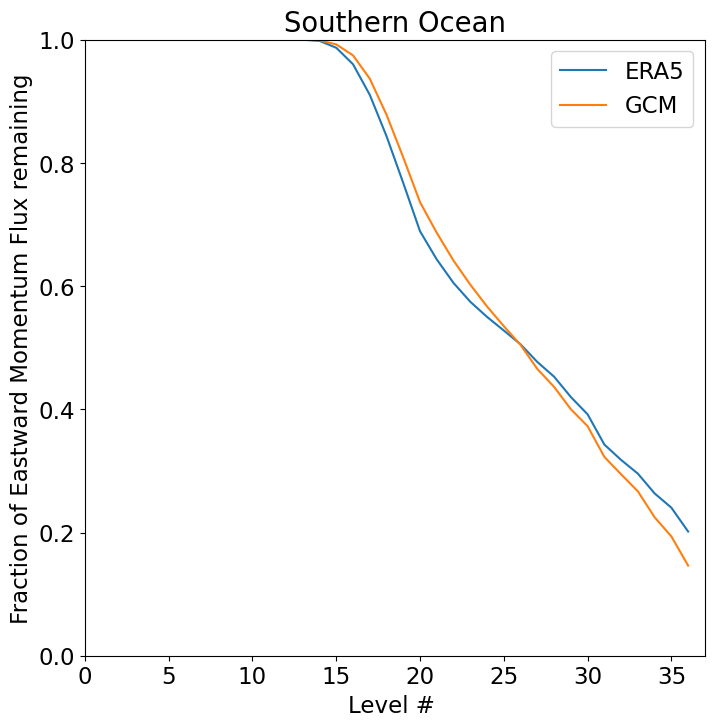

In [7]:
plt.plot(remaining_flux_eastward_era5.mean(axis=(0,1)),label='ERA5')
plt.plot(remaining_flux_eastward_gcm.mean(axis=(0,1)),label='GCM')
plt.legend()
plt.gca().set_ylabel("Fraction of Eastward Momentum Flux remaining")
plt.gca().set_xlabel("Level # ")
plt.title(f"{TITLE}")
plt.ylim(0,1)
plt.xlim(0,37)

In [8]:
transmittence_mean_eastward_era5=transmittence_eastward_era5.mean(axis=(0,1))
transmittence_mean_eastward_gcm=transmittence_eastward_gcm.mean(axis=(0,1))

(0.0, 37.0)

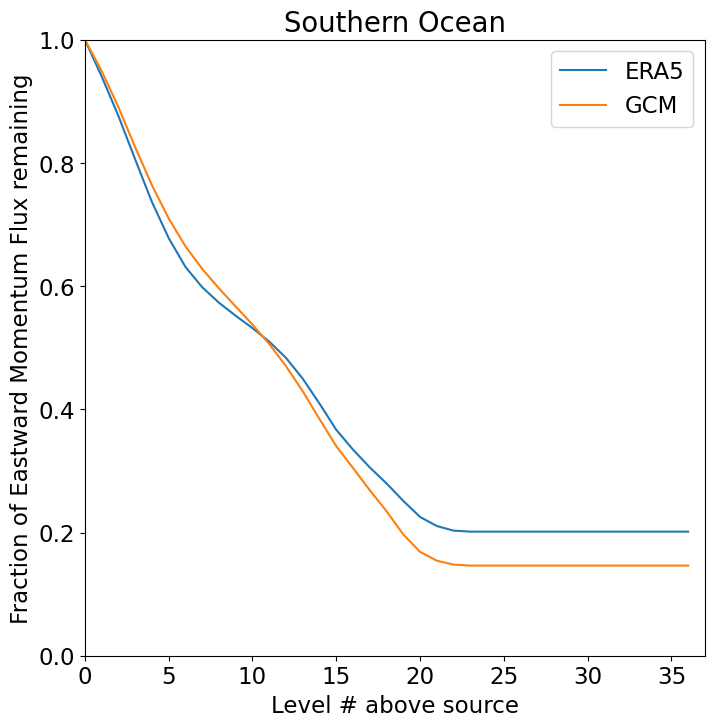

In [9]:
plt.plot(transmittence_mean_eastward_era5,label='ERA5')
plt.plot(transmittence_mean_eastward_gcm,label='GCM')
plt.legend()
plt.gca().set_ylabel("Fraction of Eastward Momentum Flux remaining")
plt.gca().set_xlabel("Level # above source")
plt.title(f"{TITLE}")
plt.ylim(0,1)
plt.xlim(0,37)

w/ samples

(0.0, 37.0)

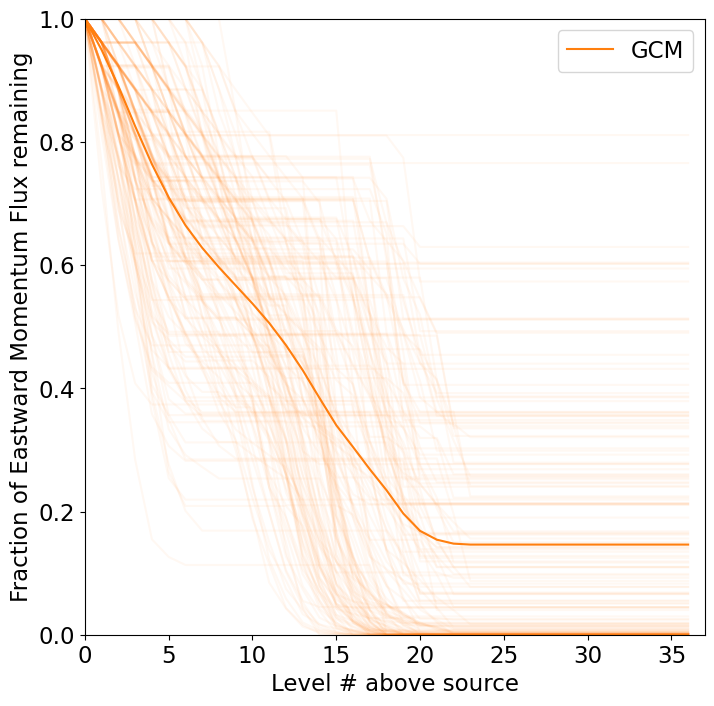

In [10]:
# plt.plot(transmittence_mean_eastward_era5,label='ERA5',color='C0')
plt.plot(transmittence_mean_eastward_gcm,label='GCM',color='C1')
for i in range(0,transmittence_eastward_gcm.shape[0],100):
    for j in range(0,transmittence_eastward_gcm.shape[1],100):
        # plt.plot(transmittence_eastward_era5[i,j],color='C0',alpha=0.1)
        plt.plot(transmittence_eastward_gcm[i,j],color='C1',alpha=0.05)

plt.legend()
plt.gca().set_ylabel("Fraction of Eastward Momentum Flux remaining")
plt.gca().set_xlabel("Level # above source")
plt.ylim(0,1)
plt.xlim(0,37)

w/samples, with seasons

In [11]:
months = np.asarray([t.astype('datetime64[M]').astype(int) %12 + 1 for t in ds_era5.time.values])

/tmp/ipykernel_41877/466560400.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0.5, 1.0, 'Southern Ocean Transmittance')

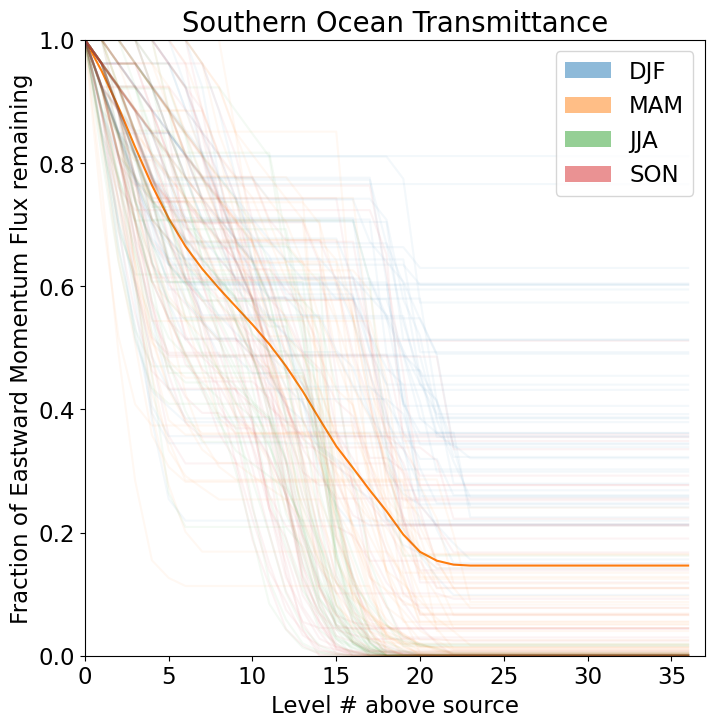

In [12]:
from matplotlib.patches import Patch
# plt.plot(transmittence_mean_eastward_era5,label='ERA5',color='C0')
plt.plot(transmittence_mean_eastward_gcm,color='C1')
for i in range(0,transmittence_eastward_gcm.shape[0],100):
    for j in range(0,transmittence_eastward_gcm.shape[1],100):
        season =months[i]%12 // 3
        # plt.plot(transmittence_eastward_era5[i,j],color='C0',alpha=0.1)
        plt.plot(transmittence_eastward_gcm[i,j],color=f'C{season}',alpha=0.05)

plt.legend()
plt.gca().set_ylabel("Fraction of Eastward Momentum Flux remaining")
plt.gca().set_xlabel("Level # above source")
plt.ylim(0,1)
plt.xlim(0,37)
plt.legend(
    [
        Patch(facecolor='C0',alpha=0.5),
        Patch(facecolor='C1',alpha=0.5),
        Patch(facecolor='C2',alpha=0.5),
        Patch(facecolor='C3',alpha=0.5)
    ],
    ['DJF','MAM','JJA','SON'],
)
plt.title(f'{TITLE} Transmittance')

(0.0, 37.0)

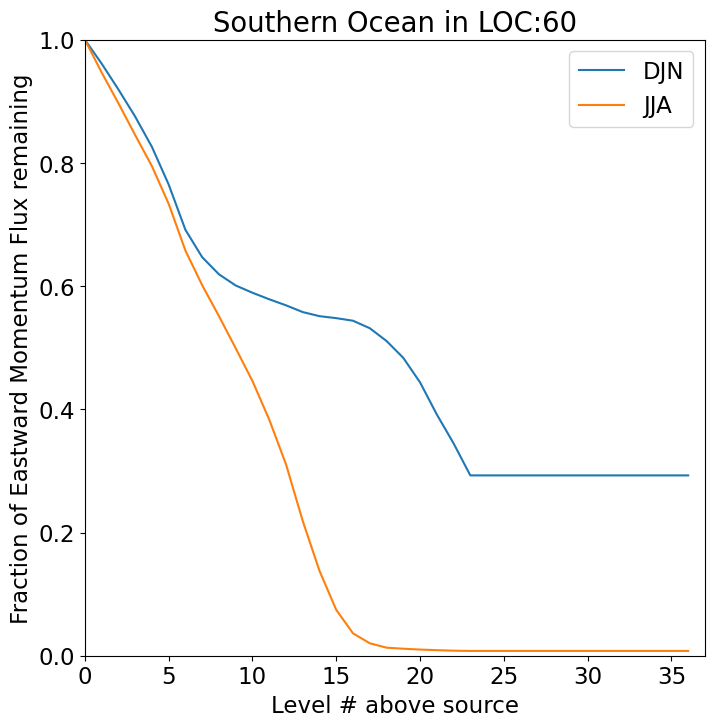

In [13]:
LOC = 60
transmittence_mean_eastward_gcm_djn=transmittence_eastward_era5[:int(4*30*2),LOC].mean(axis=(0,))
transmittence_mean_eastward_gcm_jja=transmittence_eastward_era5[int(4*30*6):int(4*30*9),LOC].mean(axis=(0,))

plt.plot(transmittence_mean_eastward_gcm_djn,label='DJN')
plt.plot(transmittence_mean_eastward_gcm_jja,label='JJA')
plt.legend()
plt.gca().set_ylabel("Fraction of Eastward Momentum Flux remaining")
plt.gca().set_xlabel("Level # above source")
plt.title(f"{TITLE} in LOC:{LOC}")
plt.ylim(0,1)
plt.xlim(0,37)

### Plot vs height


(0.0, 1.0)

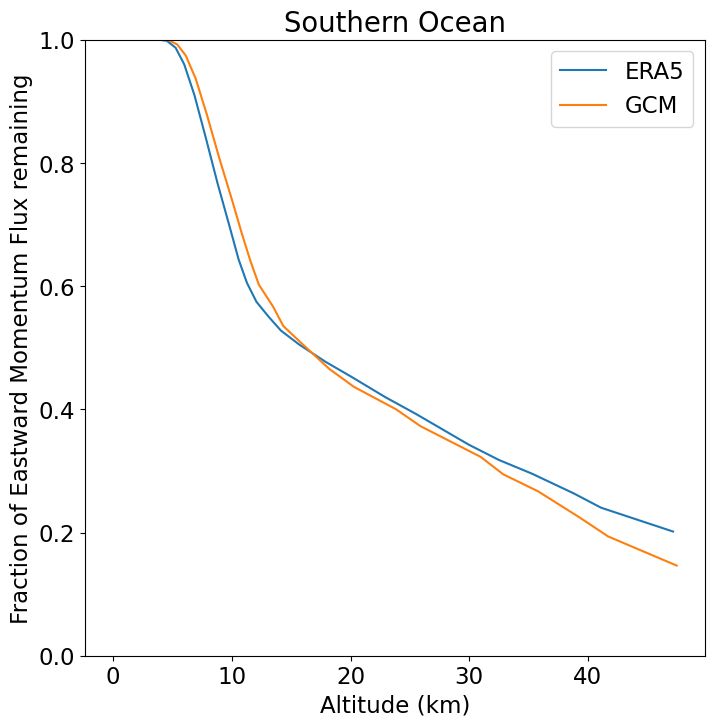

In [14]:
plt.plot(ds_gcm.z.data.mean(axis=(0,1))/1000,remaining_flux_eastward_era5.mean(axis=(0,1)),label='ERA5')
plt.plot(ds_era5.z.data.mean(axis=(0,1))/1000,remaining_flux_eastward_gcm.mean(axis=(0,1)),label='GCM')
plt.legend()
plt.gca().set_ylabel("Fraction of Eastward Momentum Flux remaining")
plt.gca().set_xlabel("Altitude (km)")
plt.title(f"{TITLE}")
plt.ylim(0,1)


In [15]:
from ad99py import AlexanderDunkerton1999

def get_transmittence_with_height(flux,z,lat):
    ad99 = AlexanderDunkerton1999()

    remaining_flux = flux / flux[...,0,None]
    batch_shape = flux.shape[:-1]
    n_levels = flux.shape[-1]
    remaining_flux_flt = remaining_flux.reshape(-1,n_levels)
    z_flt = z.reshape(-1,n_levels)
    lat_flt = lat.reshape(-1,n_levels)

    fluxes = []
    heights = []

    remaining_flux_flt_adjust = np.ones_like(remaining_flux_flt)*np.nan
    z_abv_src_adjust = np.ones_like(z_flt)*np.nan
    for i in range(remaining_flux_flt.shape[0]):
        src = ad99.get_source_level(z_flt[i],lat_flt[i])
        slice_flux =remaining_flux_flt[i,src:] 
        remaining_flux_flt_adjust[i,:slice_flux.shape[-1]] = slice_flux 
        z_abv_src_adjust[i,:slice_flux.shape[-1]] = np.clip(z_flt[i,src:] - ad99.get_source_height(lat_flt[i,0]),0,np.inf)
        heights.append(z_flt[i,src:])

    z_abv_src = z_abv_src_adjust.reshape((*batch_shape,n_levels))
    remaining_flux_adjust = remaining_flux_flt_adjust.reshape((*batch_shape,n_levels))
    return remaining_flux_adjust,z_abv_src 
    



In [16]:
transmittence_eastward_era5_upad, z_above_era5 = get_transmittence_with_height(ds_era5.gw_flux_eastward.data,ds_era5.z.data,era5_lat)
transmittence_eastward_gcm_upad, z_above_gcm = get_transmittence_with_height(ds_gcm.gw_flux_eastward.data,ds_gcm.z.data,gcm_lat)

/tmp/ipykernel_41877/534835295.py:1: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean( z_above_era5 ,axis=(0,1))/1000,np.nanmean(transmittence_eastward_era5_upad,axis=(0,1)),label='ERA5')
/tmp/ipykernel_41877/534835295.py:2: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean( z_above_gcm,axis=(0,1))/1000,np.nanmean(transmittence_eastward_gcm_upad,axis=(0,1)),label='GCM')


Text(0.5, 1.0, 'Southern Ocean Seasonal Variance')

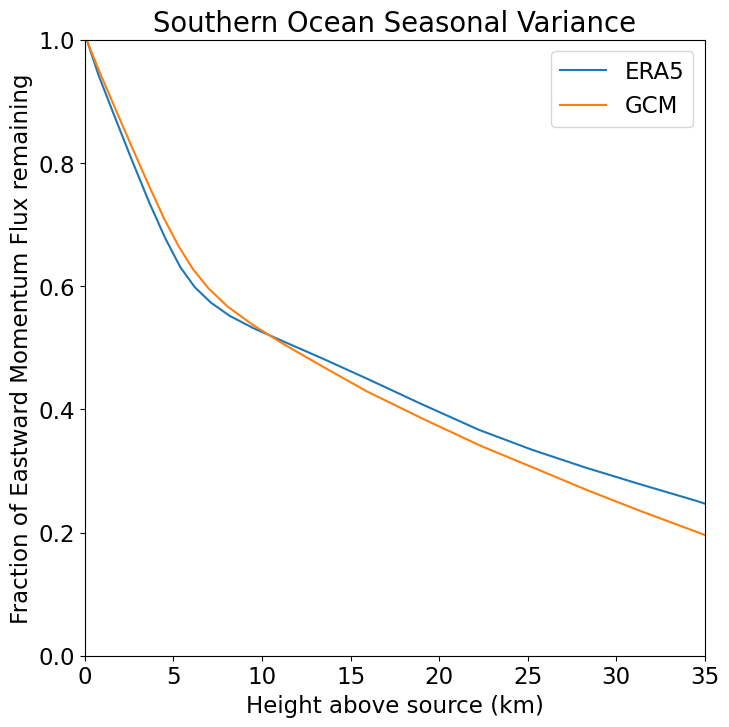

In [17]:
plt.plot(np.nanmean( z_above_era5 ,axis=(0,1))/1000,np.nanmean(transmittence_eastward_era5_upad,axis=(0,1)),label='ERA5')
plt.plot(np.nanmean( z_above_gcm,axis=(0,1))/1000,np.nanmean(transmittence_eastward_gcm_upad,axis=(0,1)),label='GCM')
plt.legend()
plt.gca().set_ylabel("Fraction of Eastward Momentum Flux remaining")
plt.gca().set_xlabel("Height above source (km)")
plt.ylim(0,1)
plt.xlim(0,35)
plt.title(f"{TITLE} Seasonal Variance")


/tmp/ipykernel_41877/857119271.py:1: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean( z_above_era5[:,LOC] ,axis=0)/1000,np.nanmean(transmittence_eastward_era5_upad[:,LOC],axis=0),label='ERA5')


Text(0.5, 1.0, 'Southern Ocean')

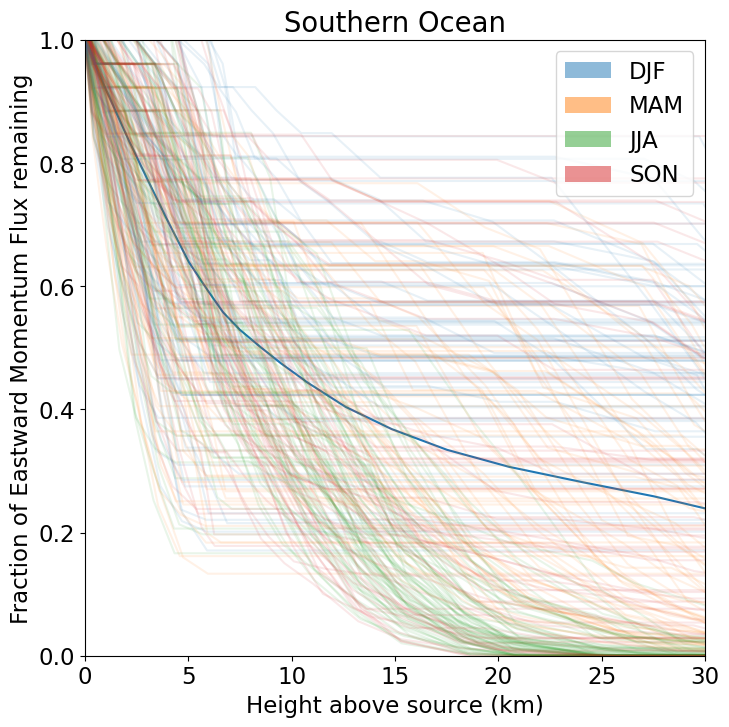

In [18]:


plt.plot(np.nanmean( z_above_era5[:,LOC] ,axis=0)/1000,np.nanmean(transmittence_eastward_era5_upad[:,LOC],axis=0),label='ERA5')
# plt.plot(np.nanmean( z_above_gcm,axis=(0,1))/1000,np.nanmean(transmittence_eastward_gcm_upad,axis=(0,1)),label='GCM')
for i in range(0,z_above_era5[:,LOC].shape[0],5):
    season =months[i]%12 // 3
    plt.plot(z_above_era5[i,LOC]/1000,transmittence_eastward_era5_upad[i,LOC],color=f'C{season}',alpha=0.1)
plt.legend()
plt.gca().set_ylabel("Fraction of Eastward Momentum Flux remaining")
plt.gca().set_xlabel("Height above source (km)")
plt.ylim(0,1)
plt.xlim(0,30)
plt.legend([
        Patch(facecolor='C0',alpha=0.5),
        Patch(facecolor='C1',alpha=0.5),
        Patch(facecolor='C2',alpha=0.5),
        Patch(facecolor='C3',alpha=0.5)
    ],
    ['DJF','MAM','JJA','SON'],
)
plt.title(f"{TITLE}")

/tmp/ipykernel_41877/506289709.py:2: RuntimeWarning: Mean of empty slice
  np.nanmean(
/tmp/ipykernel_41877/506289709.py:6: RuntimeWarning: Mean of empty slice
  np.nanmean(
/tmp/ipykernel_41877/506289709.py:13: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean( z_above_gcm[int(6*30*4):int(9*30*4)],axis=(0,1))/1000,np.nanmean(transmittence_eastward_gcm_upad[int(6*30*4):int(9*30*4)],axis=(0,1)),label='JJA')


(0.0, 35.0)

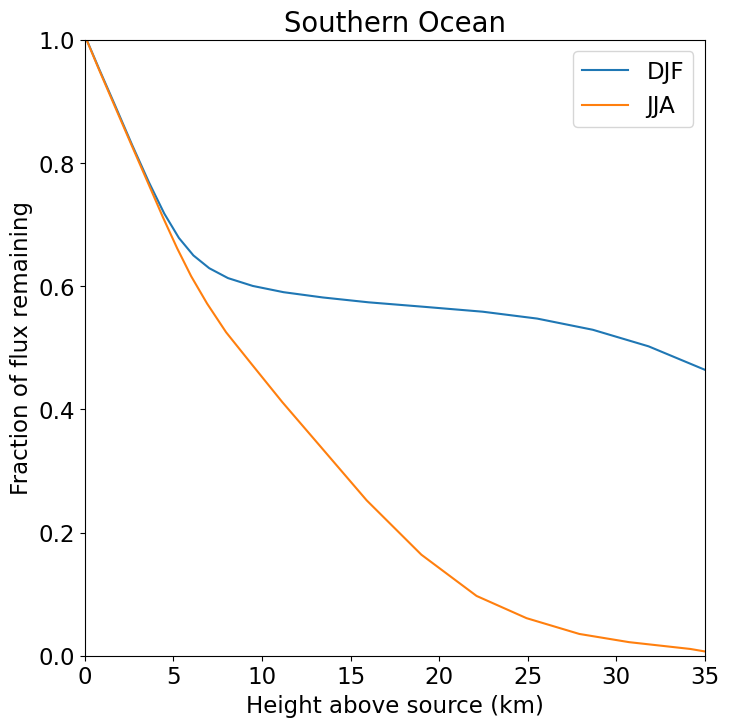

In [20]:
plt.plot(
    np.nanmean(
         np.concatenate([z_above_gcm[:int(2*30*4)],z_above_gcm[int(11*30*4):]]),
         axis=(0,1)
    )/1000,
    np.nanmean( 
        np.concatenate(
            [transmittence_eastward_gcm_upad[:int(2*30*4)],
            transmittence_eastward_gcm_upad[int(11*30*4):]])
        ,axis=(0,1)
    
    ),label='DJF')
plt.plot(np.nanmean( z_above_gcm[int(6*30*4):int(9*30*4)],axis=(0,1))/1000,np.nanmean(transmittence_eastward_gcm_upad[int(6*30*4):int(9*30*4)],axis=(0,1)),label='JJA')
plt.legend()
plt.gca().set_ylabel("Fraction of flux remaining")
plt.gca().set_xlabel("Height above source (km)")
plt.ylim(0,1)
plt.title(f"{TITLE}")
plt.xlim(0,35)
